VCG (Virtual Center Guided) TSP
핵심 아이디어:
TSP는 위상적으로 원을 구성하는 구조라는 가정에서 출발

따라서 전체 점을 둘러싼 **가상 중심(center of tour)**이 있을 것이라 보고,
이 중심 방향을 따라 점들을 순회하면 효율적일 것이라고 가정

동작 절차:
모든 점의 중심 (centroid)을 계산

시작점을 하나 고름 (임의 혹은 가장 좌측)

다음 점은 아직 방문하지 않은 점 중에서

중심을 향하는 방향성(dot product)

**거리(euclidean distance)**에 기반해
score = α · 방향성 - β · 거리 로 점수 계산

점수가 가장 높은 점을 선택

모든 점을 방문할 때까지 반복

시작점으로 돌아오면서 순환 TSP 경로 완성

주요 하이퍼파라미터:
alpha: 중심 방향성 가중치

beta: 거리 페널티 가중치

관찰된 효과:
점들이 **국소성(Locality)**을 띄는 경우(예: PCB layout), 굉장히 효율적

적절한 (α, β) 조합일 경우 기존 2-approximation 알고리즘보다 성능 우수

최적 값 예시:

(α=0.5, β=1.5) 또는 (α=0.5, β=2.0) → 성능 매우 우수

예: pcb442 문제에서 약 60,000 수준 도달 (Optimal ≈ 50,000)

✅ 1. 이론적 배경
📌 1.1 Standard VCG (Virtual Center Guided) TSP
목표:
유클리드 공간 상의 도시들에 대해, 중심점과의 상대적 위치를 이용하여 탐욕적으로 경로를 구성하는 Heuristic TSP 알고리즘.

핵심 아이디어:

전체 도시들의 중심점(C_global)을 기준으로 탐색 방향을 설정

현재 위치에서 다음 방문 후보에 대해:

center_direction: 중심 방향 벡터

candidate_direction: 후보 도시로 향하는 벡터

이 두 벡터 간 **cosine 유사도(dot product)**를 계산하여 중심 쪽으로 이동 유인을 부여

거리 기반 페널티도 함께 부여하여 점수가 높은 도시를 다음 경로로 선택

스코어 함수:

score
(
𝑖
)
=
𝛼
⋅
cos
⁡
(
𝜃
𝑖
)
−
𝛽
⋅
𝑑
(
𝑖
)
scale
score(i)=α⋅cos(θ
i
​
 )−β⋅
scale
d(i)
​

𝛼
α: 중심 방향 유인 강화

𝛽
β: 거리 페널티 조절

scale: 정규화를 위한 거리 스케일링 (예: 100)

In [ ]:
# --- 1. TSP 파일 파싱 함수 ---
def parse_tsp_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    coords = []
    start = False
    for line in lines:
        if "NODE_COORD_SECTION" in line:
            start = True
            continue
        if "EOF" in line:
            break
        if start:
            parts = line.strip().split()
            if len(parts) >= 3:
                coords.append((float(parts[1]), float(parts[2])))
    return coords


# --- 2. 거리 계산 함수 ---
def euclidean(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) ** 0.5


# --- 3. 개선된 중심 기반 경로 확장 알고리즘 ---
def vcg_tsp(points, alpha=1.0, beta=1.0):
    import math

    n = len(points)
    visited = [False] * n
    path = []

    # 전체 중심 계산
    C_global = (
        sum([p[0] for p in points]) / n,
        sum([p[1] for p in points]) / n
    )

    # 시작점: 중심에 가장 가까운 점
    start = min(range(n), key=lambda i: euclidean(points[i], C_global))
    curr = start
    path.append(curr)
    visited[curr] = True

    for _ in range(n - 1):
        curr_point = points[curr]

        # 현재까지 경로의 중심 재계산 (C_tour)
        tour_center = (
            sum(points[i][0] for i in path) / len(path),
            sum(points[i][1] for i in path) / len(path)
        )

        # 중심 방향 계산
        center_dir = (
            C_global[0] - curr_point[0],
            C_global[1] - curr_point[1]
        )
        norm_cd = math.hypot(*center_dir) + 1e-8
        center_dir = (center_dir[0]/norm_cd, center_dir[1]/norm_cd)

        candidates = []
        for i in range(n):
            if visited[i]:
                continue
            direction = (points[i][0] - curr_point[0], points[i][1] - curr_point[1])
            dist_to_candidate = euclidean(curr_point, points[i])
            norm_dir = math.hypot(*direction) + 1e-8
            unit_dir = (direction[0]/norm_dir, direction[1]/norm_dir)
            dot = unit_dir[0] * center_dir[0] + unit_dir[1] * center_dir[1]

            score = alpha * dot - beta * (dist_to_candidate / 100.0)  # normalize distance scale
            candidates.append((score, i))

        _, next_node = max(candidates)
        path.append(next_node)
        visited[next_node] = True
        curr = next_node

    path.append(start)  # 순환 경로
    return path


# --- 4. 경로 길이 계산 ---
def total_path_length(path, points):
    return sum(euclidean(points[path[i]], points[path[i+1]]) for i in range(len(path)-1))


# --- 5. 시각화 (옵션) ---
def plot_path(path, points):
    import matplotlib.pyplot as plt
    tour = [points[i] for i in path]
    xs, ys = zip(*tour)
    plt.figure(figsize=(8, 6))
    plt.plot(xs, ys, marker='o')
    plt.title("VCG v2 TSP Path")
    plt.show()

Saving a280.tsp to a280 (3).tsp
alpha=0.5, beta=0.5, 길이=11372.9935
alpha=0.5, beta=1.0, 길이=6334.9599
alpha=0.5, beta=1.5, 길이=5021.1704
alpha=0.5, beta=2.0, 길이=4404.3134
alpha=1.0, beta=0.5, 길이=28954.9242
alpha=1.0, beta=1.0, 길이=11372.9935
alpha=1.0, beta=1.5, 길이=7417.9095
alpha=1.0, beta=2.0, 길이=6334.9599
alpha=1.5, beta=0.5, 길이=48409.9850
alpha=1.5, beta=1.0, 길이=16437.0963
alpha=1.5, beta=1.5, 길이=11372.9935
alpha=1.5, beta=2.0, 길이=8341.4467

✅ 최적 결과:
alpha=0.5, beta=2.0, 길이=4404.3134
✅ 총 점 개수: 280
✅ 유일한 경로 점 수: 280
✅ 순환 여부: ✔️
✅ 총 경로 길이: 4404.313388613911


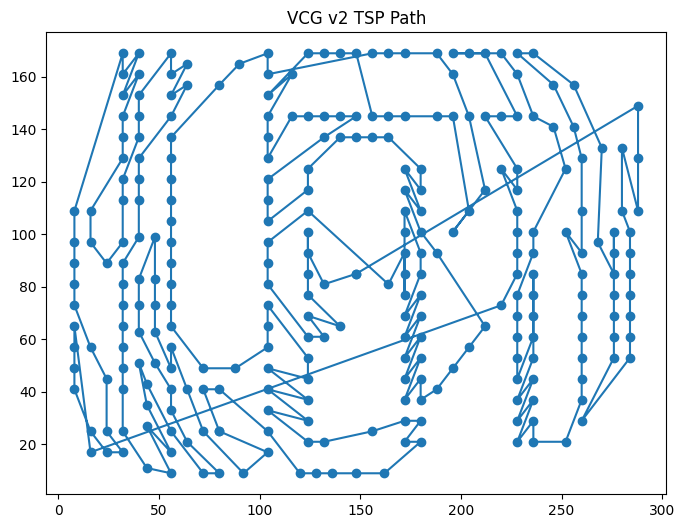

In [ ]:
# 📁 STEP 1: Colab에서 tsp 파일 업로드
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))  # 업로드된 첫 번째 파일명


# 📁 STEP 2: 파싱한 좌표로 알고리즘 실행
points = parse_tsp_file(filename)

# 하이퍼파라미터 그리드 탐색
best_path = None
best_length = float("inf")
best_alpha = None
best_beta = None

for alpha in [0.5, 1.0, 1.5]:
    for beta in [0.5, 1.0, 1.5, 2.0]:
        tsp_path = vcg_tsp(points, alpha=alpha, beta=beta)
        length = total_path_length(tsp_path, points)
        print(f"alpha={alpha}, beta={beta}, 길이={length:.4f}")
        if length < best_length:
            best_length = length
            best_path = tsp_path
            best_alpha = alpha
            best_beta = beta

# 📌 결과 출력
print("\n✅ 최적 결과:")
print(f"alpha={best_alpha}, beta={best_beta}, 길이={best_length:.4f}")
print("✅ 총 점 개수:", len(points))
print("✅ 유일한 경로 점 수:", len(set(best_path)))  # 중복 체크
print("✅ 순환 여부:", "✔️" if best_path[0] == best_path[-1] else "❌")
print("✅ 총 경로 길이:", total_path_length(best_path, points))
plot_path(best_path, points)


Saving a280.tsp to a280 (4).tsp
alpha=0.1, beta=0.5, 길이=4026.8857
alpha=0.1, beta=1.0, 길이=3556.0926
alpha=0.1, beta=1.5, 길이=3474.2808
alpha=0.1, beta=1.75, 길이=3440.4842
alpha=0.1, beta=2.0, 길이=3440.1920
alpha=0.1, beta=2.25, 길이=3342.3088
alpha=0.1, beta=2.5, 길이=3288.6974
alpha=0.2, beta=0.5, 길이=5660.3027
alpha=0.2, beta=1.0, 길이=4026.8857
alpha=0.2, beta=1.5, 길이=3476.3220
alpha=0.2, beta=1.75, 길이=3499.0190
alpha=0.2, beta=2.0, 길이=3556.0926
alpha=0.2, beta=2.25, 길이=3597.9630
alpha=0.2, beta=2.5, 길이=3462.7151
alpha=0.3, beta=0.5, 길이=7110.9909
alpha=0.3, beta=1.0, 길이=4783.7303
alpha=0.3, beta=1.5, 길이=4026.8857
alpha=0.3, beta=1.75, 길이=3790.5660
alpha=0.3, beta=2.0, 길이=3703.9795
alpha=0.3, beta=2.25, 길이=3476.3220
alpha=0.3, beta=2.5, 길이=3605.8580
alpha=0, beta=0.5, 길이=3331.0486
alpha=0, beta=1.0, 길이=3331.0486
alpha=0, beta=1.5, 길이=3331.0486
alpha=0, beta=1.75, 길이=3331.0486
alpha=0, beta=2.0, 길이=3331.0486
alpha=0, beta=2.25, 길이=3331.0486
alpha=0, beta=2.5, 길이=3331.0486
alpha=4, beta=0.5, 길이=

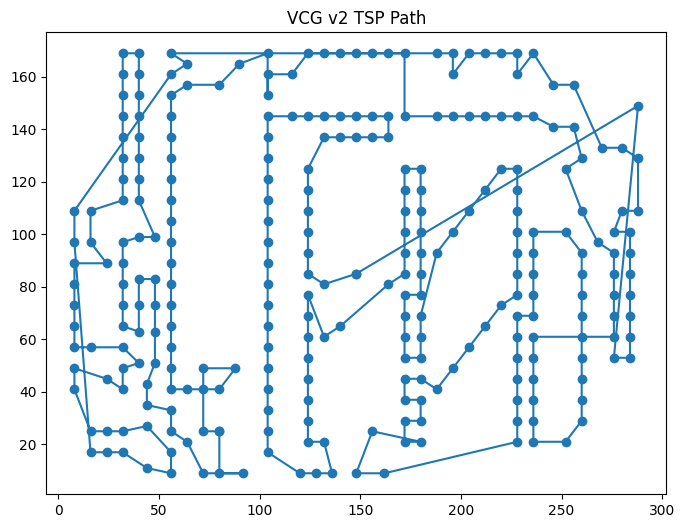

In [ ]:
# 📁 STEP 1: Colab에서 tsp 파일 업로드
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))  # 업로드된 첫 번째 파일명


# 📁 STEP 2: 파싱한 좌표로 알고리즘 실행
points = parse_tsp_file(filename)

# 하이퍼파라미터 그리드 탐색
best_path = None
best_length = float("inf")
best_alpha = None
best_beta = None


for alpha in [0.1, 0.2, 0.3, 0,4, 0.5, 1.0, 1.5]:
    for beta in [0.5, 1.0, 1.5, 1.75, 2.0, 2.25, 2.5]:
        tsp_path = vcg_tsp(points, alpha=alpha, beta=beta)
        length = total_path_length(tsp_path, points)
        print(f"alpha={alpha}, beta={beta}, 길이={length:.4f}")
        if length < best_length:
            best_length = length
            best_path = tsp_path
            best_alpha = alpha
            best_beta = beta

# 📌 결과 출력
print("\n✅ 최적 결과:")
print(f"alpha={best_alpha}, beta={best_beta}, 길이={best_length:.4f}")
print("✅ 총 점 개수:", len(points))
print("✅ 유일한 경로 점 수:", len(set(best_path)))  # 중복 체크
print("✅ 순환 여부:", "✔️" if best_path[0] == best_path[-1] else "❌")
print("✅ 총 경로 길이:", total_path_length(best_path, points))
plot_path(best_path, points)


일반적으로 (0.5, 1.5)와 (0.5, 2.0)에서 성능이 잘 나옴
alpha를 더 낮추고 beta를 2.0 언저리에서 놀게 하면 성능이 확실히 좋아짐 -> 6000대에서 3300정도로 감소

그래서 local이 많이 있는 PCB442 데이터로 실험(맨 아래)
=> optimal 50000에 (0.3, 2.5) 일때 60000으로 성능이 꽤 좋음

또한 alpha를 많이 낮추지 않아도 괜찮음
-> alpha는 방향성 점수 가중치
-> beta는 장거리 penalty계수 이므로

지역성이 강한 모델에서는 alpha를 높이고, 지역성이 약한 모델에서는 alpha를 어느정도 낮출 필요가 있어보임 => 동적 결정이 가능한가?

In [ ]:
# 📁 STEP 1: Colab에서 tsp 파일 업로드
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))  # 업로드된 첫 번째 파일명


# 📁 STEP 2: 파싱한 좌표로 알고리즘 실행
points = parse_tsp_file(filename)

# 하이퍼파라미터 그리드 탐색
best_path = None
best_length = float("inf")
best_alpha = None
best_beta = None

for alpha in [0.5, 1.0, 1.5]:
    for beta in [0.5, 1.0, 1.5, 2.0]:
        tsp_path = vcg_tsp(points, alpha=alpha, beta=beta)
        length = total_path_length(tsp_path, points)
        print(f"alpha={alpha}, beta={beta}, 길이={length:.4f}")
        if length < best_length:
            best_length = length
            best_path = tsp_path
            best_alpha = alpha
            best_beta = beta

# 📌 결과 출력
print("\n✅ 최적 결과:")
print(f"alpha={best_alpha}, beta={best_beta}, 길이={best_length:.4f}")
print("✅ 총 점 개수:", len(points))
print("✅ 유일한 경로 점 수:", len(set(best_path)))  # 중복 체크
print("✅ 순환 여부:", "✔️" if best_path[0] == best_path[-1] else "❌")
print("✅ 총 경로 길이:", total_path_length(best_path, points))
plot_path(best_path, points)


Saving kz9976.tsp to kz9976.tsp
alpha=0.5, beta=0.5, 길이=1403563.1912
alpha=0.5, beta=1.0, 길이=1350590.6902
alpha=0.5, beta=1.5, 길이=1345997.6279
alpha=0.5, beta=2.0, 길이=1371214.7800


KeyboardInterrupt: 

현재의 중심 유도 모델은 “전략적 전체 흐름”은 유도하지만, 실제 경로 최적화는 거리 기반이 훨씬 더 강력함.
따라서 중심은 방향 힌트만 주되, 본질은 여전히 가까운 점끼리 연결하는 지역 전략이 성능을 좌우함.

Saving pcb442.tsp to pcb442 (3).tsp
alpha=0.01, beta=0.5, 길이=64605.2803
alpha=0.01, beta=1.0, 길이=64605.2803
alpha=0.01, beta=1.5, 길이=64605.2803
alpha=0.01, beta=2.0, 길이=64605.2803
alpha=0.1, beta=0.5, 길이=60015.6625
alpha=0.1, beta=1.0, 길이=61602.2761
alpha=0.1, beta=1.5, 길이=62422.5095
alpha=0.1, beta=2.0, 길이=62422.5095
alpha=0.2, beta=0.5, 길이=64646.3016
alpha=0.2, beta=1.0, 길이=60015.6625
alpha=0.2, beta=1.5, 길이=64391.3994
alpha=0.2, beta=2.0, 길이=61602.2761
alpha=0.3, beta=0.5, 길이=65439.6851
alpha=0.3, beta=1.0, 길이=64125.6800
alpha=0.3, beta=1.5, 길이=60015.6625
alpha=0.3, beta=2.0, 길이=64391.3994
alpha=0.5, beta=0.5, 길이=70935.7688
alpha=0.5, beta=1.0, 길이=66429.7664
alpha=0.5, beta=1.5, 길이=62397.9774
alpha=0.5, beta=2.0, 길이=63363.7891
alpha=1.0, beta=0.5, 길이=74572.4247
alpha=1.0, beta=1.0, 길이=70935.7688
alpha=1.0, beta=1.5, 길이=68480.4965
alpha=1.0, beta=2.0, 길이=66429.7664
alpha=1.5, beta=0.5, 길이=85734.9808
alpha=1.5, beta=1.0, 길이=73566.4901
alpha=1.5, beta=1.5, 길이=70935.7688
alpha=1.5, beta

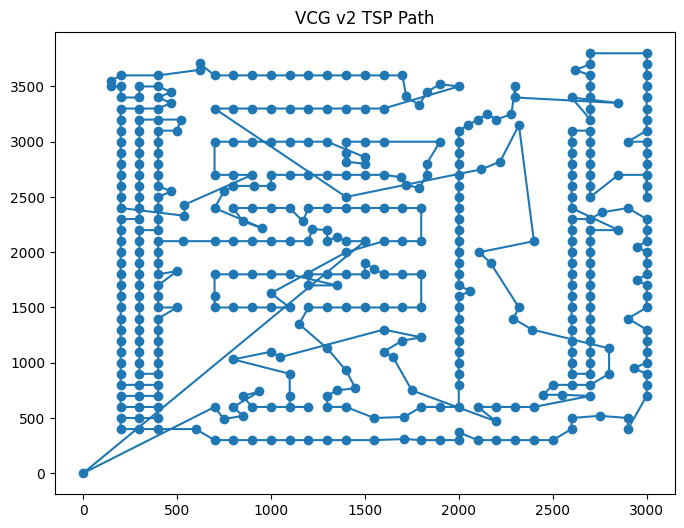

In [ ]:
# 📁 STEP 1: Colab에서 tsp 파일 업로드
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))  # 업로드된 첫 번째 파일명


# 📁 STEP 2: 파싱한 좌표로 알고리즘 실행
points = parse_tsp_file(filename)

# 하이퍼파라미터 그리드 탐색
best_path = None
best_length = float("inf")
best_alpha = None
best_beta = None

for alpha in [0.01, 0.1, 0.2, 0.3, 0.5, 1.0, 1.5]:
    for beta in [0.5, 1.0, 1.5, 2.0]:
        tsp_path = vcg_tsp(points, alpha=alpha, beta=beta)
        length = total_path_length(tsp_path, points)
        print(f"alpha={alpha}, beta={beta}, 길이={length:.4f}")
        if length < best_length:
            best_length = length
            best_path = tsp_path
            best_alpha = alpha
            best_beta = beta

# 📌 결과 출력
print("\n✅ 최적 결과:")
print(f"alpha={best_alpha}, beta={best_beta}, 길이={best_length:.4f}")
print("✅ 총 점 개수:", len(points))
print("✅ 유일한 경로 점 수:", len(set(best_path)))  # 중복 체크
print("✅ 순환 여부:", "✔️" if best_path[0] == best_path[-1] else "❌")
print("✅ 총 경로 길이:", total_path_length(best_path, points))
plot_path(best_path, points)


지역성 있는 데이터 셋에서 성능이 꽤 좋게 나옴